<a href="https://colab.research.google.com/github/Ankit-LASA/Data-Science/blob/main/AnkiBhasU7proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install bambi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.1 MB/s eta 0:00:00


In [60]:
!pip install preliz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.1/517.1 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 23.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [61]:
import preliz as pz
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt
import bambi as bmb

# Introduction: Unit 7 Project

It's the academic consensus that increased carbon emissions has been globally warming the planet over the years. Recently, many people claim that 'hotter' weather is attributable to such trends, while other merely state they're more closely tied to the seasons and that confirmation bias drives such statements.

To investigate the correlation, I decided to find a dataset of temperatures over an extremely long timeframe. Specifically, I chose a dataset of the temperatures in Yakutsk, Russia --- a region in Siberia that experiences particularly cold temperatures. To isolate and account for such factors, I sought to find the optimal model for the data.

The data collected numerous factors including the year, month, and degrees. The temperature ranges from around -50 to 20 degrees per year, but the question of whether such ranges are changing over the years will be investigated.

In [3]:
#to begin with, I decided to combine this years data (24-25) into the original dataset
temp = pd.read_csv('https://raw.githubusercontent.com/Ankit-LASA/Data-Science/refs/heads/main/Unit7/Temperature.csv').dropna()
temp

,Year,Month,Data #,Degrees
0,1882,1,1,-10.6
1,1882,2,2,-35.6
2,1882,3,3,-40.6
3,1882,4,4,-42.3
4,1882,5,5,-36.5
...,...,...,...,...
1363,1995,8,1364,7.2
1364,1995,9,1365,17.2
1365,1995,10,1366,19.2
1366,1995,11,1367,13.2


To help with my modelling, I begun by setting up a scatterplot of the months by degrees and year by degrees.

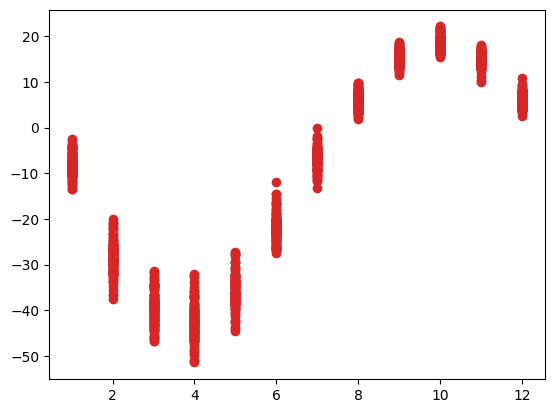

In [10]:
plt.scatter(temp.Month, temp.Degrees, c='C3')

The dataset looks cubic, so my early prediction is that a polynomial might be the best predictor.

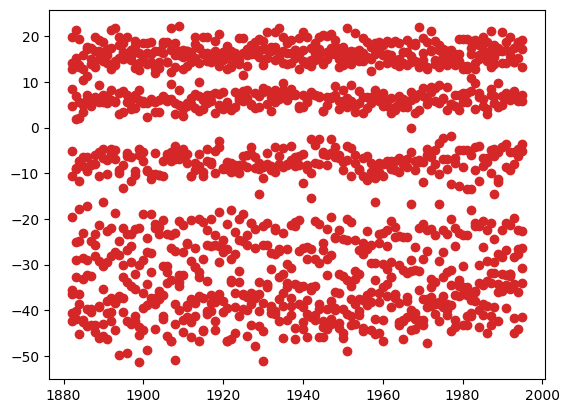

In [8]:
plt.scatter(temp.Year, temp.Degrees, c='C3')

As you can see, there is 4 subsections for each season: Summer, Fall, Winter, Spring for their according temperatures.

# Model

First, I sought to replicate the cubic nature of the first scatterplot. I'm going to use a polynomial because it's the easiest way to account for that.

In [45]:
#cubic polynomial
model_poly = bmb.Model("Degrees ~ poly(Month, degree=3)", temp)
idata_poly = model_poly.fit(idata_kwargs={"log_likelihood":True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


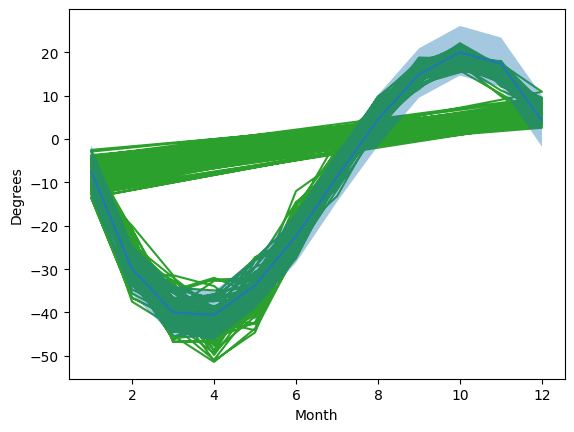

In [48]:
#plot
bmb.interpret.plot_predictions(model_poly, idata_poly, "Month", pps=True)
plt.plot(temp.Month, temp.Degrees, "C2", zorder=-3)

While it may initially seem like the graph is wildly off due to the straight line running through the cubic, the model is actually a good fit. The model added the linear line due to a miscalculation that the months are discrete which distorted the data. As such, we can discount the the linear line running through the data.

Next, I wanted to add year predictors to observe the impacts of warming too. To have variety in the models and optimize, I'm choosing to add Year straight up and add it as a polynomial. The downside is that I won't be able to graph it due to it having multiple predictors that don't necessarily match up very well.

In [51]:
#cubic polynomial with year
model_poly2 = bmb.Model("Degrees ~ poly(Month, degree=3) + Year", temp)
idata_poly2 = model_poly2.fit(idata_kwargs={"log_likelihood":True})

Output()

In [52]:
#cubic polynomial with year as a linear polynomial
model_poly3 = bmb.Model("Degrees ~ poly(Month, degree=3) + poly(Year, degree=1)", temp)
idata_poly3 = model_poly3.fit(idata_kwargs={"log_likelihood":True})

Output()

Next, I sought to create a BS to model the data. I thought that maybe it could replicate the seasons as it splits from 1 to 12

In [71]:
num_knots = 4
knots = np.linspace(0, 12, num_knots+2)[1:-1]
model_spline = bmb.Model("Degrees ~ bs(Month, degree=3, knots=knots)", temp)
idata_spline = model_spline.fit(idata_kwargs={"log_likelihood":True})

Output()

/usr/local/lib/python3.11/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


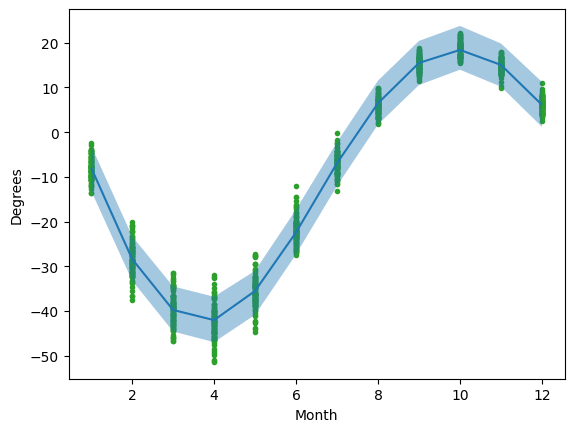

In [72]:
bmb.interpret.plot_predictions(model_spline, idata_spline, "Month", pps= True)
plt.plot(temp.Month, temp.Degrees, "C2.", zorder=-3)

This looks pretty good! Next, I'll add the year variables in there.

In [76]:
num_knots = 4
knots = np.linspace(0, 12, num_knots+2)[1:-1]
model_spline2 = bmb.Model("Degrees ~ bs(Month, degree=3, knots=knots) + Year", temp)
idata_spline2 = model_spline2.fit(idata_kwargs={"log_likelihood":True})

Output()

In [78]:
num_knots = 4
knots = np.linspace(0, 12, num_knots+2)[1:-1]
model_spline3 = bmb.Model("Degrees ~ bs(Month, degree=3, knots=knots) + poly(Year, degree=1)", temp)
idata_spline3 = model_spline3.fit(idata_kwargs={"log_likelihood":True})

Output()

In [80]:
compare = az.compare({"polynomial":idata_poly, "polynomial w/ year":idata_poly2, "polynomial w/ year polynomial":idata_poly3, "bspline":idata_spline, "bspline w/ year":idata_spline2, "bspline w/ year polynomial":idata_spline3})
compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
bspline w/ year,0,-3277.219297,10.429963,0.000000,9.662230e-01,34.196171,0.000000,False,log
bspline,1,-3277.421081,10.654019,0.201784,5.967449e-16,34.155189,0.089799,False,log
bspline w/ year polynomial,2,-3277.648147,10.988187,0.428850,4.606391e-16,34.240340,0.107307,False,log
polynomial w/ year polynomial,3,-3463.594460,5.637291,186.375163,3.377702e-02,29.307238,17.345891,False,log
polynomial w/ year,4,-3463.954826,5.988775,186.735529,0.000000e+00,29.347501,17.360679,False,log
polynomial,5,-3463.998825,6.035987,186.779528,8.881784e-16,29.335810,17.347000,False,log


According to the elpd_loo, the best model in order is: bspline w/ year, bspline, bspline w/ year as a polynomial, polynomial w/ year polynomial, polynomial w/ year, polynomial. However, the amount of variables changes the accuracy significantly (which will be further explained below).

# Model

After looking at the elpd_loo values, the best model is likely the polynomial without the year variable. Even though it's the lowest elpd_loo value, thereby going against conventional wisdom, I believed it was more accurate than the data represented for a couple of reasons:

1.   Errors in the polynomial modelling: The initial model had an accurate cubic expression. However, due to a modelling error explained above in which there's a linear line at the ends, it's distorted. The actual model should be much more accurate, which could be a reason to discount the statistics in the elpd_loo model.
2.   Bspline fragments for months: The bspline can only colect at intervals of three. However, because December (month 12) and other parts of winter in January aren't in the same subsection, the data isn't entirely correct. That is the reason why even without using the elpd_loo values the polynomial model should theoretically provide a better model.

Furthermore, I believed discounting the year variable would do well to maintain the accuracy of the data. When compared with the other polynomial models' elpd_loos (which all should have the same errors, allowing to isolate the effect of the year), the change is marginal while adding another variable.


 Using my chosen model indicates that months alone is a stronger predictor than including a given year. That contradicts the idea that warming, over the years, has significantly changed daily temperatures more than the seasons of the year. While it is true that warming led to marginal increases in the daily weather, the seasons have shifted it far more. By the 90s (where the worst effects of warming hadn't yet been felt), the globe had been warmed by less than 2 degrees, while the seasons have contributed to 70 degree shifts in weather.

 This shows that attributing particularly extreme temperatures on a given day shouldn't solely fall on warming. The location and season may have a larger effect that strongly overwhelms any percieved 'change' in our daily lives. Therefore, the next time you face a hot Summer day in Texas, know that it's mostly due to where you live, not climate change alone.

 In the future, I would likely choose data over multiple areas with more recent timeframes to better capture the more recent effects of warming. Past data is criticized for using false collection methods which thereby distorts the weather. I would additionally rerun the modelling to box out the linear line error in the polynomial graph. The assortment of these should significantly improve the models accuracy in the real world, better answering the question of whether the season or anthropogenic climate change should be blamed for your weather.



# Extra GP Testing

Didn't really get this to work at the end because the GP doesn't work well with the gaps in the months

In [66]:
#setting up GP model
#ig stands for inverse gamma
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.96, plot=False):
    """
    Returns a weakly informative prior for the length-scale parameter of the GP kernel.
    """
    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5
    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)
    return dict(zip(dist.param_names, dist.params))
#numpy arrays
month = temp["Month"].values[:,None]
degrees = temp["Degrees"].values

In [65]:
month.size

1368

In [69]:
with pm.Model() as model_hsgp:
    #prior for our smoothness parameter
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(month))
    #this is our kernal, which decides how our points relate to one another
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    #this specfices that we're using an HSGP
    gp = pm.gp.HSGP(m=[10], c=1.5, cov_func=cov)
    #f is for function, as in the function we use to transform our data
    f = gp.prior('f', X = month)
    #prior for the neg binomial
    α = pm.HalfNormal('α', 1)
    #likelihood
    y = pm.NegativeBinomial("y", np.exp(f), α, observed=degrees)
    idata_hsgp = pm.sample()

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'ℓ_log__': array(2.38660673), 'f_hsgp_coeffs': array([-0.98115478,  0.2971977 ,  0.77767204,  0.09736158,  0.55896449,
       -0.29268467, -0.04705687,  0.03192332,  0.27121494,  0.28470897]), 'α_log__': array(-0.50812356)}

Logp initial evaluation results:
{'ℓ': -4.01, 'f_hsgp_coeffs': -10.3, 'α': -0.91, 'y': -inf}
You can call `model.debug()` for more details.